In [1]:
import json
import pandas as pd
import spacy
import numpy as np
import gym
import tensorflow as tf
import copy
import random
import pylab
import os
import gzip
from urllib.request import urlopen
from collections import deque
from keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Load JSON data
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz

data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
# Let's take a peek at the first row and the total number of rows
print(len(data))
print(data[0])

883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [3]:
df = pd.DataFrame(data)
df = df[['overall','verified','reviewerID','asin','style','reviewerName','reviewText', 'summary','reviewTime']]
# Filter verified reviews with non-null overall ratings
filtered_df = df[(df['verified'] == True) & (~df['overall'].isnull())]

In [4]:
filtered_df

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,reviewTime
0,5.0,True,A1D4G1SNUZWQOT,7106116521,NaN,Tracy,Exactly what I needed.,perfect replacements!!,"10 20, 2014"
1,2.0,True,A3DDWDH9PX2YX2,7106116521,NaN,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...","09 28, 2014"
3,2.0,True,A2UH2QQ275NV45,7106116521,NaN,Jodi Stoner,too tiny an opening,Two Stars,"08 24, 2014"
5,5.0,True,A29HLOUW0NS0EH,7106116521,NaN,Patricia R. Erwin,Exactly what I wanted.,Five Stars,"07 19, 2014"
6,4.0,True,A7QS961ROI6E0,7106116521,NaN,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,"05 31, 2014"
...,...,...,...,...,...,...,...,...,...
883631,5.0,True,A1ZSB2Q144UTEY,B01HJHTH5U,NaN,Amazon Customer,I absolutely love this dress!! It's sexy and ...,I absolutely love this dress,"02 21, 2017"
883632,5.0,True,A2CCDV0J5VB6F2,B01HJHTH5U,NaN,Amazon Customer,I'm 5'6 175lbs. I'm on the tall side. I wear a...,I wear a large and ordered a large and it stil...,"11 25, 2016"
883633,3.0,True,A3O90PACS7B61K,B01HJHTH5U,NaN,Fabfifty,Too big in the chest area!,Three Stars,"11 10, 2016"
883634,3.0,True,A2HO94I89U3LNH,B01HJHF97K,NaN,Mgomez,"Too clear in the back, needs lining",Three Stars,"11 10, 2016"


In [5]:
# Create Empty class for data representation
class FashionProduct() : pass
class Reviewer() : pass
reviewers = {}
grouped_df_reviwerId = filtered_df.groupby('reviewerID')
counter = 0

# Group reviews by reviewers, select users with more than 10 purchases
for reviewerId, group in grouped_df_reviwerId:
    products = group[group['asin'].notna()]['asin'].unique()
    if len(products) > 10:
        reviewer = Reviewer()
        reviewer.reviewerId = reviewerId
        reviewer.products = products
        reviewers[reviewerId] = reviewer
        counter += 1

In [9]:
reduced_filtered_df = filtered_df[(filtered_df['reviewerID'].isin([reviewer for reviewer, _ in reviewers.items()]))]
reduced_filtered_df['reviewTime'] = pd.to_datetime(reduced_filtered_df['reviewTime'])
reduced_filtered_df.sort_values('reviewTime')
grouped_df = reduced_filtered_df.groupby(['asin', 'reviewerID', 'reviewTime'], sort=False)

/var/folders/2t/0zz876bx1rb5xlfb0ky3m7j40000gn/T/ipykernel_34586/3587300947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_filtered_df['reviewTime'] = pd.to_datetime(reduced_filtered_df['reviewTime'])


In [10]:
nlp = spacy.load('en_core_web_sm')

# We extract the nouns and imporntant words from text
def extract_nouns(doc):
    return " ".join([token.text for token in doc if token.pos_ == "NOUN" or token.pos_ == "PROPN"])

# Storing products and states as dictionaries
states = {}
products = {}

# Iterate over each product, and create a Fashion Product Object
for (product_asin, reviewerId, reviewTime), group in grouped_df:
    if (product_asin, reviewerId) in states: continue
    product = FashionProduct()
    product.product_asin = product_asin
    product.reviewerId = reviewerId
    product.time = reviewTime
    if product_asin not in products:
        products[product_asin] = product
        p= products[product_asin]
        p.reviewers = set()
        p.sizes = set()
        p.colors = set()
        p.reviews = set()
        p.rating =[]
    product.reviewers = products[product_asin].reviewers

    # Get relevant information about the product, like the size and color
    styles=  group[group['style'].notna()]['style']
    sizes = styles.apply(lambda x: x.get("Size:", "") if "Size:" in x else x.get("Size Name:", "")).unique().tolist()
    colors = styles.apply(lambda x: x.get("Color:", "")).unique().tolist()
    products[product_asin].sizes.update(sizes)
    products[product_asin].colors.update(colors)
    reviews = group[group['reviewText'].notna()]['reviewText']
    reviews = " ".join(reviews.apply(lambda x: " ".join([extract_nouns(chunk) for chunk in nlp(x).noun_chunks]).strip()).unique())
    products[product_asin].reviews.update(reviews)
    ratings = group[group['overall']>0]['overall'].tolist()
    products[product_asin].rating.extend(ratings)
    product.ratings = np.sqrt(np.mean( [r**2 for r in products[product_asin].rating])) # Get RMS of product rating
    sizes = " ".join(products[product_asin].sizes)
    colors = " ".join(products[product_asin].colors)
    reviews = " ".join(products[product_asin].reviews)
    product.metadata= " ".join((reviews+" "+sizes+" "+colors).split())

    # Add last 2 reviews of product as metadata
    for reviewer in list(product.reviewers)[-2:]:
        state = states[(product_asin, reviewer)]
        product.metadata += " "+state.metadata

    # keep past reviewer list
    products[product_asin].reviewers.add(reviewerId)
    states[(product_asin, reviewerId)] = product

states_list= list(states.values())
states_list = [s for s in states_list if s.metadata.strip() != '']

In [11]:
grouped_df.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,reviewTime
3368,5.0,True,AAC2BU2V9X95K,B000EE1NNA,"{'Size:': ' Large', 'Color:': ' Blue/Red'}",me,Happy with it,Five Stars,2016-07-22
12731,5.0,True,A1H2WJSALF3E9U,B000KPIHQ4,"{'Size Name:': ' Men's 12-13.5, Women's 14-15....",Papa T,These best Super Feet. I feel these are as com...,What is not to love.,2017-05-01
16417,5.0,True,A2IQT5AFFXA1OM,B000NBIMG0,"{'Size:': ' 39/40 BR/9-10 M US', 'Color:': ' N...",Tina Diane,Perfect,Love them,2017-07-06
17435,5.0,True,A2T2ZJ8NQ7PP5J,B000NGJ41W,{'Size:': ' 9'},Ruth U.,Love these rings. Nice to have a choice to ma...,Five Stars,2014-09-23
26234,5.0,True,A1H2WJSALF3E9U,B000V0IBDM,NaN,Papa T,These best Super Feet. I feel these are as com...,What is not to love.,2017-05-01
...,...,...,...,...,...,...,...,...,...
880242,4.0,True,AWXWY3KTKIDWG,B01HBJW7DU,NaN,Laura W.,NIce,Four Stars,2017-05-24
880512,5.0,True,A1IBM7TVYJFVCM,B01HC6I664,NaN,Youhavenoidea,Runs just below ribs nice stretch to it. Runs ...,Five Stars,2016-08-06
882748,1.0,True,A16QST8AO6TXX3,B01HH3WJVA,NaN,Picky bee-eye,These broke really fast. A screw came out the ...,so I really hate to say they're not great,2017-04-24
883234,4.0,True,AZD378NGJIDQH,B01HI84VBA,NaN,DK,I wound up ordering 3 of these... the sizing w...,Its a beautiful dress. I'll be selling the sma...,2016-08-22


In [20]:
# Creatiing a sample recommendation environment

class RecommendationEnv(gym.Env):
    def __init__(self, states, states_dict, iterations = 10):
        self.states = states
        self.state = self.states[0]
        self.states_dict = states_dict
        self.iterations = iterations
        self.index = 0
        state.action = 0


    def step(self, actions):
        reward= 0
        done= False
        reviewerId= self.state.reviewerId
        future_asins= [p for p in reviewers[reviewerId].products if self.states_dict[(p,reviewerId)].time>self.state.time]
        matched_recommendations = False
        #predicted recommendations
        for i in actions:
          if self.states[i].product_asin in future_asins:
            self.action = i
            matched_recommendations = True
            break
        if matched_recommendations:
            reward = 1
        else:
            self.action = actions[0]
        self.index += 1
        self.state = self.states[self.index]
        print(f"iteration :{self.index}")
        if (self.iterations == self.index): done = True

        return self.state, reward, done, {}

    def reset(self, iterations = 10):
        # Reset the state to the initial position
        self.state = self.states[0]
        self.iterations = iterations
        self.index = 0
        return self.state

# Create the custom environment
env = RecommendationEnv(states_list, states, 10)

In [ ]:
# Implementation of DQN algorithm
class DQNAgent:
    def __init__(self, state_size, action_size, states):
        self.states = states
        self.state_size = state_size
        self.action_size = action_size

        # Hyperpraameters
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # Replay memory buffer
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        self.update_target_model()


    def build_model(self):
        # RNN for text classification
        encoder = tf.keras.layers.TextVectorization(max_tokens=10000) # TextVectorization layer to normalize, split, and map strings
        metadatas = [product.metadata for product in self.states]
        ratings = [product.ratings for product in self.states]
        encoder.adapt(metadatas)

        model = tf.keras.Sequential([
            encoder,
            layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),  # Embedding layer
            layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(32)),  
            layers.Dense(64, activation='relu'),  
            layers.Dense(32, activation='relu'),  
            layers.Dense(10, activation='softmax')  
        ])
        ratings_input = tf.keras.layers.Input(shape=(1,), name='ratings_input')
        concatenated = layers.concatenate([model.output, ratings_input])
        dense_layer = layers.Dense(64, activation='relu')(concatenated)
        output_layer = layers.Dense(len(self.states), activation='linear')(dense_layer)

        model = tf.keras.Model(inputs=[model.input, ratings_input], outputs=output_layer)
        model.summary()

        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.sample(range(self.action_size),10)
        else:
            q_value = self.model.predict([np.array([state.metadata]), np.array([state.ratings])])
            return np.argpartition(q_value[0],-10)[-10:]

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input_metadata =[]
        update_input_ratings =[]
        update_target_metadata = []
        update_target_ratings = []
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input_metadata.append(np.array(mini_batch[i][0].metadata))
            update_input_ratings.append(np.array(mini_batch[i][0].ratings))
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target_metadata.append(np.array(mini_batch[i][3].metadata))
            update_target_ratings.append(np.array(mini_batch[i][3].ratings))
            done.append(mini_batch[i][4])

        target = self.model.predict([np.transpose(update_input_metadata),np.transpose(update_input_ratings)])
        target_val = self.target_model.predict([np.transpose(update_target_metadata),np.transpose(update_target_ratings)])

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * ( np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit([np.transpose(update_input_metadata),np.transpose(update_input_ratings)], target, batch_size=self.batch_size,
                       epochs=1, verbose=1)

state_size = len(env.states)
# Every other product can be a recommendation
action_size = state_size
agent = DQNAgent(state_size, action_size, env.states)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_vectorization_5_input (In  [(None,)]           0           []                               
 putLayer)                                                                                        
                                                                                                  
 text_vectorization_5 (TextVect  (None, None)        0           ['text_vectorization_5_input[0][0
 orization)                                                      ]']                              
                                                                                                  
 embedding_5 (Embedding)        (None, None, 64)     14848       ['text_vectorization_5[0][0]']   
                                                                                            

In [27]:
scores, episodes = [], []
EPISODES = 50
next_states = {}
done_value = {}
action_value = {}
for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset(50)

    while not done:
        if (state.product_asin, state.reviewerId) in next_states:
          next_state = next_states[(state.product_asin, state.reviewerId)]
          reward = 1
          done = done_value[(state.product_asin, state.reviewerId)]
          action = action_value[(state.product_asin, state.reviewerId)]
          env.index += 1
        else:
          # get action for the current state and go one step in environment
          actions = agent.get_action(state)
          next_state, reward, done, info = env.step(actions)
          action = env.action
          if (reward == 1):
            next_states[(state.product_asin, state.reviewerId)]= next_state
            done_value[(state.product_asin, state.reviewerId)] = done
            action_value[(state.product_asin, state.reviewerId)] = env.action

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            scores.append(score)
            episodes.append(e)
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)
    if (score > 50): break

iteration :1
iteration :2
iteration :3
iteration :4
iteration :5
iteration :6
iteration :7
iteration :8
iteration :9
iteration :10
iteration :11
iteration :12
iteration :13
iteration :14
iteration :15
iteration :16
iteration :17
iteration :18
iteration :19
iteration :20
iteration :21
iteration :22
iteration :23
iteration :24
iteration :25
iteration :26
iteration :27
iteration :28
iteration :29
iteration :30
iteration :31
iteration :32
iteration :33
iteration :34
iteration :35
iteration :36
iteration :37
iteration :38
iteration :39
iteration :40
iteration :41
iteration :42
iteration :43
iteration :44
iteration :45
iteration :46
iteration :47
iteration :48
iteration :49
iteration :50
episode: 0   score: 2   memory length: 50   epsilon: 0.9512056281970315
iteration :1
iteration :2
iteration :3
iteration :4
iteration :5
iteration :6
iteration :7
iteration :8
iteration :9
iteration :10
iteration :11
1/1 [==============================] - 1s 1s/step
iteration :12
iteration :13
iteration :14


2024-12-16 11:08:59.948392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-12-16 11:09:00.157814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-12-16 11:09:01.353807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

1/1 [==============================] - 6s 6s/step - loss: 7.5021e-04
episode: 19   score: 25   memory length: 1000   epsilon: 0.3676954247709635
1/1 [==============================] - 0s 9ms/step
iteration :1
1/1 [==============================] - 0s 8ms/step
iteration :2
1/1 [==============================] - 0s 70ms/step - loss: 6.3228e-04
iteration :3
1/1 [==============================] - 0s 79ms/step - loss: 5.7171e-04
iteration :5
1/1 [==============================] - 0s 9ms/step
iteration :6
1/1 [==============================] - 0s 9ms/step
iteration :7
1/1 [==============================] - 0s 9ms/step
iteration :8
1/1 [==============================] - 0s 10ms/step
iteration :9
1/1 [==============================] - 0s 11ms/step
iteration :10
1/1 [==============================] - 0s 12ms/step
iteration :11
1/1 [==============================] - 0s 70ms/step - loss: 4.3736e-04
iteration :12
1/1 [==============================] - 0s 10ms/step
iteration :13
1/1 [==============

Text(0.5, 1.0, 'Performance Over Episodes')

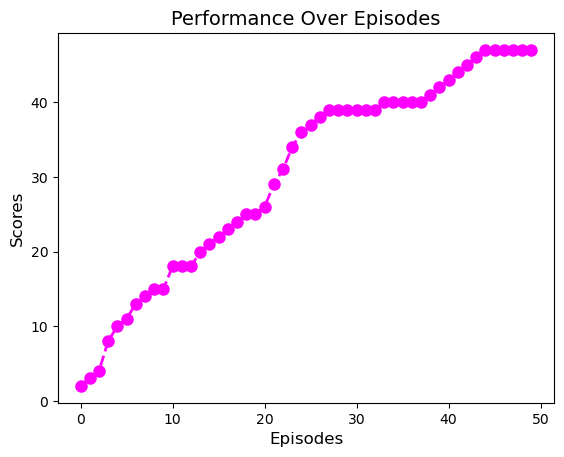

In [28]:
pylab.plot(episodes, scores, color='magenta', marker='o', linestyle='--', linewidth=2, markersize=8, label='Score Trend')

pylab.xlabel('Episodes', fontsize=12)   # X-axis label
pylab.ylabel('Scores', fontsize=12)     # Y-axis label
pylab.title('Performance Over Episodes', fontsize=14)

In [47]:
agent.model.save("dqn_model")

2024-12-16 10:26:19.744259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-16 10:26:19.744858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-16 10:26:19.745212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: dqn_model/assets


INFO:tensorflow:Assets written to: dqn_model/assets


In [22]:
# Implementing the data pipeline

from datetime import datetime
from pandas import Timestamp
import requests
import json


# Since we are using Rest API to interact with Kafka, make objects JSON serializable
def make_json_serializable(obj):
    """Recursively convert a Python object to a JSON-serializable format."""
    if isinstance(obj, dict):
        return {key: make_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(element) for element in obj]
    elif isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, tuple):
        return tuple(make_json_serializable(element) for element in obj)
    elif isinstance(obj, (int, float, str, bool, type(None))):
        return obj  # Already JSON serializable
    elif isinstance(obj, Timestamp):
        return obj.isoformat()
    else:
        return str(obj)

# This is the Kafka URL that we use. Chaange this URL based on what your Kafka Setup.
# Please check the readme for the Kafka setup, and paste the URL that is created, over here.
ngrok_url = "https://4339-130-65-254-13.ngrok-free.app"


# Produce State. Function for the environment to produce a state and push it to Kafka
def produce_state(state):
    topic = "fashion_state"
    payload = state.__dict__
    payload = make_json_serializable(payload)
    data = {"records": [{"value": payload}]}
    print(payload)
    headers = {"Content-Type": "application/vnd.kafka.json.v2+json"}
    response = requests.post(f"{ngrok_url}/topics/{topic}", headers=headers, data=json.dumps(data))
    return response

# Initialize the Consumer state
def initialize_consumer_state():

    headers = {
    "Content-Type": "application/vnd.kafka.v2+json"
    }
    payload = {
        "name": "my_consumer_instance",
        "format": "json",
        "auto.offset.reset": "earliest"
    }

    response = requests.post(f"{ngrok_url}/consumers/my_consumer_group_state", headers=headers, data=json.dumps(payload))
    print(response.status_code, response.json())
    consumer_base_url = response.json().get("base_uri")

# Subscribe the consumer to a Kafka topic. If you are following the readme leave the topic as fashion state, else enter your own topic in the payload.
def subscribe_consumer_state():
    headers = {
        "Content-Type": "application/vnd.kafka.v2+json"
    }
    payload = {
        "topics": ["fashion_state"]
    }

    response = requests.post(f"{ngrok_url}/consumers/my_consumer_group_state/instances/my_consumer_instance/subscription", headers=headers, data=json.dumps(payload))
    print(response.status_code, response.text)

# Consume message for particular state topic
def consume_state():
    headers = {
        "Accept": "application/vnd.kafka.json.v2+json"
    }

    response = requests.get(f"{ngrok_url}/consumers/my_consumer_group_state/instances/my_consumer_instance/records", headers=headers)
    if response.status_code == 200:
        print(response.json())  # Successfully retrieved messages
    else:
        print(response.status_code, response.text) 
    return response.json()

# Produce Action. Function for the environment to produce an Action and push it to Kafka
def produce_actions(actions):
    if isinstance(actions, np.ndarray):
        actions = actions.tolist()
    data = {"records": [{"value": {"actions":actions}}]}
    topic = "fashion_action"
    headers = {"Content-Type": "application/vnd.kafka.json.v2+json"}
    response = requests.post(f"{ngrok_url}/topics/{topic}", headers=headers, data=json.dumps(data))
    return response


# Initialize the consumer action
def initialize_consumer_action():

    headers = {
    "Content-Type": "application/vnd.kafka.v2+json"
    }
    payload = {
        "name": "my_consumer_instance",
        "format": "json",
        "auto.offset.reset": "earliest"
    }

    response = requests.post(f"{ngrok_url}/consumers/my_consumer_group", headers=headers, data=json.dumps(payload))
    print(response.status_code, response.json())
    consumer_base_url = response.json().get("base_uri")

# Subscribe the consumer to the fashion_aciton topic. 
def subscribe_consumer_action():
    headers = {
        "Content-Type": "application/vnd.kafka.v2+json"
    }
    payload = {
        "topics": ["fashion_action"]
    }

    response = requests.post(f"{ngrok_url}/consumers/my_consumer_group/instances/my_consumer_instance/subscription", headers=headers, data=json.dumps(payload))
    print(response.status_code, response.text)

# Consume from the fashion_action topic
def consume_action():
    headers = {
        "Accept": "application/vnd.kafka.json.v2+json"
    }

    response = requests.get(f"{ngrok_url}/consumers/my_consumer_group/instances/my_consumer_instance/records", headers=headers)
    if response.status_code == 200:
        print(response.json())  # Successfully retrieved messages
    else:
        print(response.status_code, response.text) 
        
    return response
    

In [ ]:
state = env.reset(50)

In [220]:
from datetime import datetime

def fill_state(json_y):
    current_state = FashionProduct()
    current_state.product_asin = json_y['value']['product_asin']
    current_state.reviewerId = json_y['value']['reviewerId']
    current_state.time = pd.to_datetime(json_y['value']['time'])
    current_state.reviewers = json_y['value']['reviewers']
    current_state.sizes = json_y['value'].get('sizes') or None
    current_state.colors = json_y['value'].get('colors') or None
    current_state.reviews = json_y['value'].get('reviews') or []
    current_state.rating = json_y['value'].get('rating') or [3.0]
    current_state.ratings = json_y['value'].get('ratings') or 3.0
    current_state.metadata = json_y['value']['metadata']
    return current_state


current_state = fill_state(json_y)
current_state.__dict__

{'product_asin': 'B000EE1NNA',
 'reviewerId': 'AAC2BU2V9X95K',
 'time': Timestamp('2016-07-22 00:00:00'),
 'reviewers': ['AAC2BU2V9X95K'],
 'sizes': [' Large'],
 'colors': [' Blue/Red'],
 'reviews': [],
 'rating': [5.0],
 'ratings': 5.0,
 'metadata': 'Large Blue/Red'}

In [ ]:
# Testing an episode run using our data pipeline
# During or After running the episode, you can check your kafka clusters to see how data is being written and read
# Make sure you are connected to the right cluster by setting the correct ngrok URL.

import time

done = False
score = 0
initialize_consumer_state()
subscribe_consumer_state()
initialize_consumer_action()
subscribe_consumer_action()
state = env.reset(50)


produce_state(state)
while not done:
  current_state = consume_state()
  current_state = fill_state(current_state[-1])
  actions = agent.get_action(current_state)
  produce_actions(actions)

  current_actions = consume_action()
  current_action = np.array(current_actions.json()[-1]['value']['actions'])
  next_state, reward, done, info = env.step(current_action)

  agent.append_sample(state, action, reward, next_state, done)
  
  score += reward
  state = next_state
  produce_state(next_state)

  if (score > 50): 
    break
print(score)